# Static Analysis of Laterally-Loaded Pile Foundation

This is an interactive analysis example by where the user can gain an insight into how the finite element analysis is performed using the OpenSees framework. The interactive sliders also allow for the user to vary key parameters and see how the plotted response of the pile is influenced by these changes.

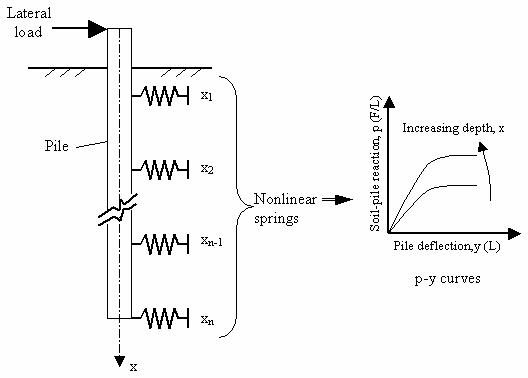
Image from Chapter 8. ANALYSES OF THE LATERAL LOAD TESTS AT THE ROUTE 351 BRIDGE, A Laboratory and Field Study of Composite Piles for Bridge Substructures, Federal Highway Administration , Miguel A. Pando, Carl D. Ealy, George M. Filz, J.J. Lesko, and E.J. Hoppe (2006)

# Finite Element Analysis Overview

Finite Element Analysis (FEA) is a numerical method which allows for an analysis of an engineering or mathematical problem where an analytical solution cannot be obtained. FEA is useful for problems with complex geometries, loadings or material properties. This analysis essentially splits a complex problem into a finite number of elements with a set number of nodes.

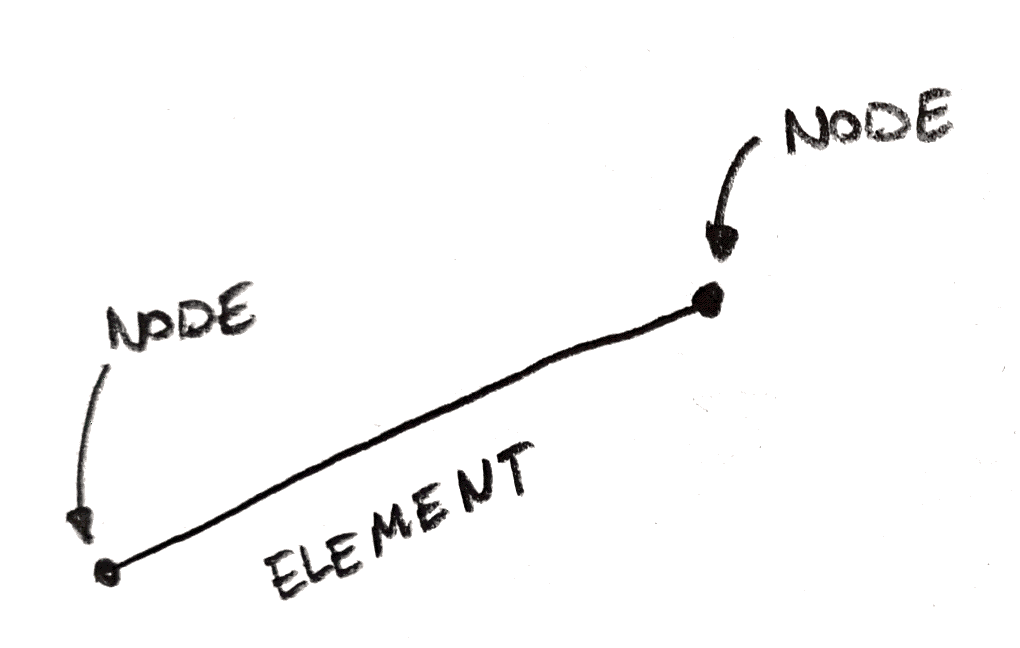
Accessed: 17.08.2022 https://enterfea.com/what-are-nodes-and-elements-in-finite-element-analysis/

Nodes and elements can be arranged in different forms to make shapes that can form two-dimensional and three-dimensional objects! Common mesh geometries look like this:

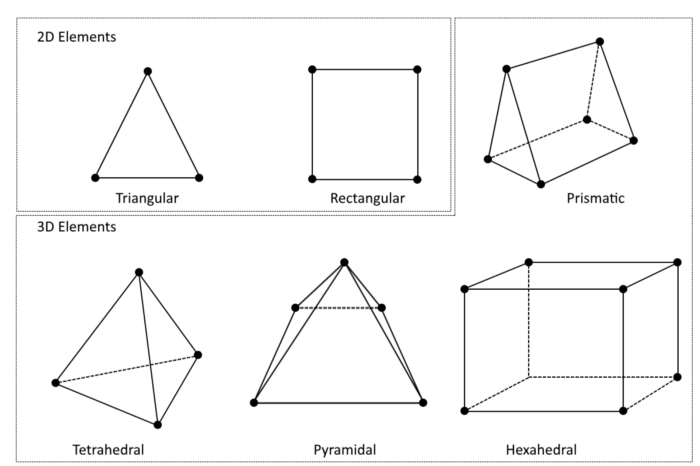
Accessed: 17.08.2022 https://medium.com/swlh/finite-element-analysis-f8eaba1ae54

# Geometry and Mesh

The geometry of this example involves a single homogenous soil layer in which the pile is embedded into. The depth to groundwater can be adjusted by the user. The meshing of the example is dictated by the pile geometry. The length of pile above the ground surface was L1 = 1 m. The length of pile embedded was 20 m.

The diameter of the pile is utilised in the soil constitutive modelling and is a variable parameter in this example. The pile geometry has 84 elements (85 nodes) which corresponds to four elements above the ground surface and 80 elements in the ground.

The pile is modeled as a beam on a nonlinear Winkler foundation. 

Lateral soil response is described by p-y springs. Vertical soil response described by t-z and q-z springs


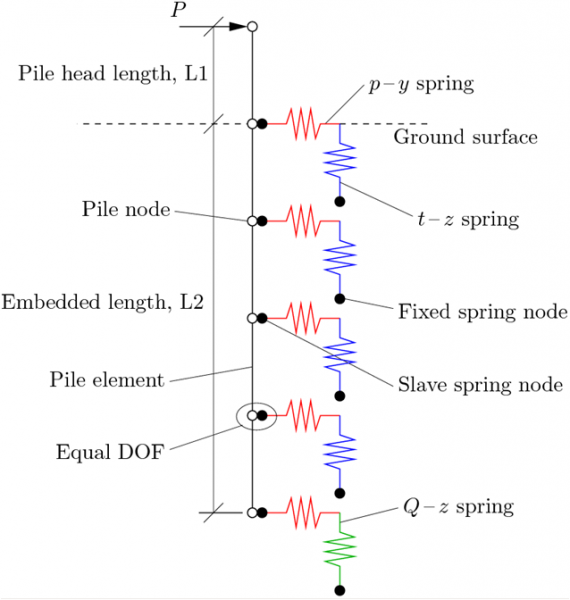

# Spring nodes

The spring nodes (t-z, q-z springs) have three dimensions and three translational degrees of freedom. Spring nodes are only created over the embedded length of pile. Input soil properties include the soil unit weight, γ, soil friction angle, ϕ, and the soil shear modulus, G. The shear modulus value was set at 150000 kPa.

# p - y curves

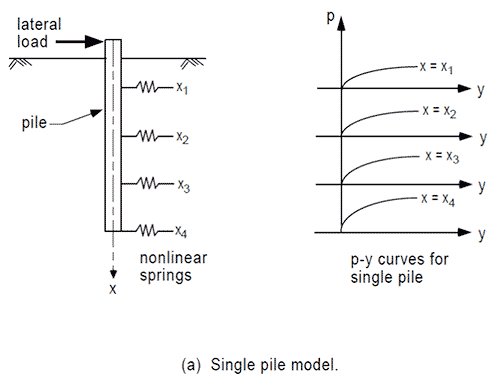
Accessed: 17.08.2022 http://www.findapile.com/p-y-curves/definition

The p-y curve is a numerical model used to represent the response of soil resistance, p, relating to the pile deflection, y.



# p-y parameters

The variation in both ultimate lateral resistance with depth, and initial stiffness with depth is computed using the recommendations of the American Petroleum Institute (API) (1993).

Common terms are defined as:

$$ \alpha = \frac{\phi}{2} \\ \beta = 45 + \frac{\phi}{2} \\  K_0 = 0.4 \\ K_a =tan^2\left(45 - \frac{\phi}{2}\right) $$

$ P_{st} $ is computed using Equation (3.44) Reese and Van Impe (2001):

$$ P_{st} = \gamma  z \left[\frac {K_0 z tan(\phi) sin(\beta)}{tan(\beta - \phi)} + \frac {tan(\beta)}{tan(\beta - \phi)} b z tan(\beta) tan(\alpha) + K_0 z tan(\beta) \Bigl(tan(\phi) sin(\beta) - tan(\alpha)\Bigl) - K_a b \right] $$

$ P_{sd} $ is computed using Equation (3.45) Reese and Van Impe (2001):

$$ P_{sd} = K_a b \gamma z \bigl( tan^8 (\beta - 1) \bigl) + K_0 b \gamma z tan(\phi) tan^4 (\beta) $$

$$ P_u = min \bigl( P_{st} , P_{sd} \bigl) $$

$ P_{ult} $ required as force, not force per length, multiply by tributary length (element size):

$$ P_{ult} = P_u  L_{element} $$

API (1987) recommended subgrade modulus for given friction angle obtained from figure (approximate).
$ y_{50} $ calculated as:

$$ y_{50} =  0.5 \left( \frac {\frac{P_{ult}}{A} } {kz} \right) \frac{1}{2} log \Bigl(\frac{1.5}{0.5}\Bigl) $$

# q-z parameters

Rigidity Index is defined as:

$$ I_r = \frac{G}{\sigma_v tan(\phi)} $$

Bearing Capacity factor:

$$ N_q = \bigl(1+2 K_0 \bigl) \Bigl(\frac{1}{3-sin(\phi)}\Bigl) \bigl(e^{\frac{\pi}{2-\phi}}\bigl) tan^2\Bigl(\frac{\pi}{4} + \frac{\phi}{2}\Bigl) I_r ^{\frac{4 sin(\phi)}{3 (1+sin(\phi))}} $$

Tip resistance:

$$ q_u = N_q \sigma_v $$

$q_{ult}$ required as a force, not stress, multiply by area of pile tip:

$$ q_{ult} = q_u \pi \frac{b^2}{4} $$

$$ z_c = 0.05 b $$

$$ z_{50} = 0.125 z_c $$

# t-z parameters

Interface friction between soil and pile, $ \delta$, taken to be 80% of internal friction angle to represent smooth precast concrete pile Kulhawy (1991)

Using Vijayvergiya (1977), assume $ z_c $ is 5% of pile diameter:

$$ \delta = 0.8 \phi $$

$$ t_u = \sigma_v \pi b tan(\delta) $$

$ t_{ult} $ required as force, not stress, multiply by tributary length (element size):

$$ t_{ult} = t_u L_{element} $$

Mosher (1984) provides recommended intial tangents based of friciton angle. $k$ is found for input value of $\phi$ using linear interpolation. $z_{50}$ is computed as follows:

$$ z_{50} = \frac{t_{ult}}{k} $$

In [1]:
#import modules

import math
import openseespy.opensees as op
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special

In [2]:
def get_pyParam ( pyDepth, gamma, phiDegree, b, pEleLength, puSwitch, kSwitch, gwtSwitch):
    
    #----------------------------------------------------------
    #  define ultimate lateral resistance, pult 
    #----------------------------------------------------------
    
    # pult is defined per API recommendations (Reese and Van Impe, 2001 or API, 1987) for puSwitch = 1
        
    pi = 3.14159265358979
    phi = phiDegree * (pi/180)
    zbRatio = pyDepth / b
    
    #-------API recommended method-------
    
    if puSwitch == 1:
    
      # obtain loading-type coefficient A for given depth-to-diameter ratio zb
      #  ---> values are obtained from a figure and are therefore approximate
        zb = []
        dataNum = 41
        for i in range(dataNum):
            b1 = i * 0.125
            zb.append(b1)
        As = [2.8460, 2.7105, 2.6242, 2.5257, 2.4271, 2.3409, 2.2546, 2.1437, 2.0575, 1.9589, 1.8973, 1.8111, 1.7372, 1.6632, 1.5893, 1.5277, 1.4415, 1.3799, 1.3368, 1.2690, 1.2074, 1.1581, 
            1.1211, 1.0780, 1.0349, 1.0164, 0.9979, 0.9733, 0.9610, 0.9487, 0.9363, 0.9117, 0.8994, 0.8994, 0.8871, 0.8871, 0.8809, 0.8809, 0.8809, 0.8809, 0.8809] 
      
        for i in range(dataNum):
            if zbRatio >= 5.0: 
                A = 0.88
            elif zb[i] <= zbRatio and zbRatio <= zb[i+1]:
                A = (As[i+1] - As[i])/(zb[i+1] - zb[i]) * (zbRatio-zb[i]) + As[i]
                
      # define common terms
        alpha = phi / 2
        beta = pi / 4 + phi / 2
        K0 = 0.4
        
        tan_1 = math.tan(pi / 4 - phi / 2)        
        Ka = math.pow(tan_1 , 2) 
    
      # terms for Equation (3.44), Reese and Van Impe (2001)
        tan_2 = math.tan(phi)
        tan_3 = math.tan(beta - phi)
        sin_1 = math.sin(beta)
        cos_1 = math.cos(alpha)
        c1 = K0 * tan_2 * sin_1 / (tan_3*cos_1)
        
        tan_4 = math.tan(beta)
        tan_5 = math.tan(alpha)
        c2 = (tan_4/tan_3)*tan_4 * tan_5
        
        c3 = K0 * tan_4 * (tan_2 * sin_1 - tan_5)
        
        c4 = tan_4 / tan_3 - Ka
    
        # terms for Equation (3.45), Reese and Van Impe (2001)
        pow_1 = math.pow(tan_4,8)
        pow_2 = math.pow(tan_4,4)
        c5 = Ka * (pow_1-1)
        c6 = K0 * tan_2 * pow_2
    
      # Equation (3.44), Reese and Van Impe (2001)
        pst = gamma * pyDepth * (pyDepth * (c1 + c2 + c3) + b * c4)
    
      # Equation (3.45), Reese and Van Impe (2001)
        psd = b * gamma * pyDepth * (c5 + c6)
    
      # pult is the lesser of pst and psd. At surface, an arbitrary value is defined
        if pst <=psd:
            if pyDepth == 0:
                pu = 0.01
              
            else:
                pu = A * pst
              
        else:
            pu = A * psd
          
      # PySimple1 material formulated with pult as a force, not force/length, multiply by trib. length
        pult = pu * pEleLength
    
            
    #----------------------------------------------------------
    #  define displacement at 50% lateral capacity, y50
    #----------------------------------------------------------
    
    # values of y50 depend of the coefficent of subgrade reaction, k, which can be defined in several ways.
    #  for gwtSwitch = 1, k reflects soil above the groundwater table
    #  for gwtSwitch = 2, k reflects soil below the groundwater table
    #  a linear variation of k with depth is defined for kSwitch = 1 after API (1987)
    #  a parabolic variation of k with depth is defined for kSwitch = 2 after Boulanger et al. (2003)
    
    # API (1987) recommended subgrade modulus for given friction angle, values obtained from figure (approximate)
    
    ph = [28.8, 29.5, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0]    
   
    # subgrade modulus above the water table
    if gwtSwitch == 1:
        k = [10, 23, 45, 61, 80, 100, 120, 140, 160, 182, 215, 250, 275]
        
    else:
        k = [10, 20, 33, 42, 50, 60, 70, 85, 95, 107, 122, 141, 155]
    
    dataNum = len(k)  
    for i in range(dataNum):
        
        if ph[i] == phiDegree:
            khat = k[i]
        
        elif ph[i] <= phiDegree and phiDegree <= ph[i+1] :
            khat = (k[i+1]-k[i])/(ph[i+1]-ph[i])*(phiDegree - ph[i]) + k[i]
            
        
            
    # change units from (lb/in^3) to (kN/m^3)
    k_SIunits = khat * 271.45
    
    # define parabolic distribution of k with depth if desired (i.e. lin_par switch == 2)
    sigV = pyDepth * gamma
    
    if sigV == 0:
         sigV = 0.01
         
    if kSwitch == 2:
       # Equation (5-16), Boulanger et al. (2003)
        cSigma = math.pow(50 / sigV , 0.5)
       # Equation (5-15), Boulanger et al. (2003)
        k_SIunits = cSigma * k_SIunits
    
    # define y50 based on pult and subgrade modulus k
    
    # based on API (1987) recommendations, p-y curves are described using tanh functions.
    #  tcl does not have the atanh function, so must define this specifically
    
    #  i.e.  atanh(x) = 1/2*ln((1+x)/(1-x)), |x| < 1
    
    # when half of full resistance has been mobilized, p(y50)/pult = 0.5
    x = 0.5
    log_1 = math.log((1+x)/(1-x))
    atanh_value = 0.5 * log_1
    
    # need to be careful at ground surface (don't want to divide by zero)
    if pyDepth == 0.0:
        pyDepth = 0.01

    y50 = 0.5 * (pu/ A)/(k_SIunits * pyDepth) * atanh_value
    # return pult and y50 parameters
    outResult = []
    outResult.append(pult)
    outResult.append(y50)
    
    return outResult

In [3]:
def get_qzParam (phiDegree, b, sigV, G):
    
    # define required constants; pi, atmospheric pressure (kPa), pa, and coeff. of lat earth pressure, Ko
    pi = 3.14159265358979
    pa = 101
    sin_4 = math.sin(phiDegree * (pi/180))
    Ko = 1 - sin_4

  # ultimate tip pressure can be computed by qult = Nq*sigV after Meyerhof (1976)
  #  where Nq is a bearing capacity factor, phi is friction angle, and sigV is eff. overburden
  #  stress at the pile tip.
    phi = phiDegree * (pi/180)  # convert phi from degrees to radians

  # rigidity index
    tan_7 = math.tan(phi)
    Ir = G/(sigV * tan_7)
  # bearing capacity factor
    tan_8 = math.tan(pi/4+phi/2)
    sin_5 = math.sin(phi)
    pow_4 = math.pow(tan_8,2)
    pow_5 = math.pow(Ir,(4*sin_5)/(3*(1+sin_5)))
    exp_4 = math.exp(pi/2-phi)
    
    Nq = (1+2*Ko)*(1/(3-sin_5))*exp_4*(pow_4)*(pow_5)  
  # tip resistance
    qu = Nq * sigV
  # QzSimple1 material formulated with qult as force, not stress, multiply by area of pile tip
    pow_6 = math.pow(b, 2)  
    qult = qu * pi*pow_6/4

  # the q-z curve of Vijayvergiya (1977) has the form, q(z) = qult*(z/zc)^(1/3)
  #  where zc is critical tip deflection given as ranging from 3-9% of the
  #  pile diameter at the tip.  

  # assume zc is 5% of pile diameter
    zc = 0.05 * b

  # based on Vijayvergiya (1977) curve, z50 = 0.125*zc
    z50 = 0.125 * zc

  # return values of qult and z50 for use in q-z material
    outResult = []
    outResult.append(qult)
    outResult.append(z50)
    
    return outResult

In [4]:
def get_tzParam ( phi, b, sigV, pEleLength):

# references
#  Mosher, R.L. (1984). "Load transfer criteria for numerical analysis of
#   axial loaded piles in sand." U.S. Army Engineering and Waterways
#   Experimental Station, Automatic Data Processing Center, Vicksburg, Miss.
#
#  Kulhawy, F.H. (1991). "Drilled shaft foundations." Foundation engineering
#   handbook, 2nd Ed., Chap 14, H.-Y. Fang ed., Van Nostrand Reinhold, New York

    pi = 3.14159265358979
    
  # Compute tult based on tult = Ko*sigV*pi*dia*tan(delta), where
  #   Ko    is coeff. of lateral earth pressure at rest, 
  #         taken as Ko = 0.4
  #   delta is interface friction between soil and pile,
  #         taken as delta = 0.8*phi to be representative of a 
  #         smooth precast concrete pile after Kulhawy (1991)
  
    delta = 0.8 * phi * pi/180

  # if z = 0 (ground surface) need to specify a small non-zero value of sigV
  
    if sigV == 0.0:
        sigV = 0.01
    
    tan_9 = math.tan(delta)
    tu = 0.4 * sigV * pi * b * tan_9
    
  # TzSimple1 material formulated with tult as force, not stress, multiply by tributary length of pile
    tult = tu * pEleLength

  # Mosher (1984) provides recommended initial tangents based on friction angle
	# values are in units of psf/in
    kf = [6000, 10000, 10000, 14000, 14000, 18000]
    fric = [28, 31, 32, 34, 35, 38]

    dataNum = len(fric)
    
    
	# determine kf for input value of phi, linear interpolation for intermediate values
    if phi < fric[0]:
        k = kf[0]
    elif phi > fric[5]:
        k = kf[5]  
    else:
        for i in range(dataNum):
            if phi == fric[i]:
                k = kf[i]
            elif fric[i] <= phi and phi <= fric[i+1]:
                k = ((kf[i+1] - kf[i])/(fric[i+1] - fric[i])) * (phi - fric[i]) + kf[i]
        

  # need to convert kf to units of kN/m^3
    kSIunits =  k * 1.885

  # based on a t-z curve of the shape recommended by Mosher (1984), z50 = tult/kf
    z50 = tult / kSIunits

  # return values of tult and z50 for use in t-z material
    outResult = []
    outResult.append(tult)
    outResult.append(z50)

    return outResult

In [5]:
def interactive_laterally_loaded_pile(gamma=17,phi=38,E=10,D=1.0,GW=2):

    op.wipe()
#########################################################################################################################################################################

#########################################################################################################################################################################

# all the units are in SI units N and mm
#150 MPa
#25 GPa

#----------------------------------------------------------
#  pile geometry and mesh
#----------------------------------------------------------

    # length of pile head (above ground surface) (m)
    L1 = 1.0
    # length of embedded pile (below ground surface) (m)
    L2 = 20.0
    # pile diameter
    #diameter = 1.0

    # number of pile elements
    nElePile = 84
    # pile element length 
    eleSize = (L1+L2)/nElePile

    # number of total pile nodes
    nNodePile =  1 + nElePile

    #----------------------------------------------------------
    #  create spring nodes
    #----------------------------------------------------------
    # spring nodes created with 3 dim, 3 dof
    op.model('basic', '-ndm', 3, '-ndf', 3) 

    # counter to determine number of embedded nodes
    count = 0

    # create spring nodes

    #1 to 85 are spring nodes

    pile_nodes = dict()

    for i in range(nNodePile):
        zCoord = eleSize * i
        if zCoord <= L2:
            op.node(i+1, 0.0, 0.0, zCoord)
            op.node(i+101, 0.0, 0.0, zCoord)
            pile_nodes[i+1] = (0.0, 0.0, zCoord)
            pile_nodes[i+101] = (0.0, 0.0, zCoord)
            count = count + 1

    #print("Finished creating all spring nodes...")

    # number of embedded nodes
    nNodeEmbed = count

    # spring node fixities
    for i in range(nNodeEmbed):
        op.fix(i+1, 1, 1, 1)
        op.fix(i+101, 0, 1, 1)

    #print("Finished creating all spring node fixities...")


#----------------------------------------------------------
#  soil properties
#----------------------------------------------------------

    # soil unit weight (kN/m^3)
    #gamma = 17.0
    # soil internal friction angle (degrees)
    #phi = 36.0
    # soil shear modulus at pile tip (kPa)
    Gsoil = 150000.0

    # select pult definition method for p-y curves
    # API (default) --> 1
    puSwitch = 1 

    # variation in coefficent of subgrade reaction with depth for p-y curves
    # API linear variation (default)   --> 1
    # modified API parabolic variation --> 2
    kSwitch = 1

    # effect of ground water on subgrade reaction modulus for p-y curves
    # above gwt --> 1
    # below gwt --> 2
    
    #gwtSwitch = 1

    #----------------------------------------------------------
    #  create spring material objects
    #----------------------------------------------------------

    # p-y spring material 

    for i in range(1 , nNodeEmbed+1):
        # depth of current py node
        pyDepth = L2 - eleSize * (i-1)
        
        if pyDepth < GW :
        
            gwtSwitch = 1
        
        else:
            gwtSwitch = 2
            
               
        # procedure to define pult and y50
        pyParam = get_pyParam(pyDepth, gamma, phi, D, eleSize, puSwitch, kSwitch, gwtSwitch)
        pult = pyParam [0]
        y50 = pyParam [1]    
        op.uniaxialMaterial('PySimple1', i, 2, pult, y50, 0.0)
        


    # t-z spring material    
    for i in range(2, nNodeEmbed+1):
      # depth of current tz node
        pyDepth = eleSize * (i-1)
      # vertical effective stress at current depth    
        sigV = gamma * pyDepth
      # procedure to define tult and z50
        tzParam = get_tzParam(phi, D, sigV, eleSize)
        tult = tzParam [0]
        z50 = tzParam [1]
        op.uniaxialMaterial('TzSimple1', i+100, 2, tult, z50, 0.0)


    # q-z spring material

      # vertical effective stress at pile tip, no water table (depth is embedded pile length)
    sigVq = gamma * L2
      # procedure to define qult and z50
    qzParam = get_qzParam (phi, D, sigVq, Gsoil)
    qult = qzParam [0]
    z50q = qzParam [1]

    #op.uniaxialMaterial('QzSimple1', 101, 2, qult, z50q) #, 0.0, 0.0
    op.uniaxialMaterial('TzSimple1', 101, 2, qult, z50q, 0.0)

    #print("Finished creating all p-y, t-z, and z-z spring material objects...")


    #----------------------------------------------------------
    #  create zero-length elements for springs
    #----------------------------------------------------------

    # element at the pile tip (has q-z spring)
    op.element('zeroLength', 1001, 1, 101, '-mat', 1, 101, '-dir', 1, 3)

    # remaining elements
    for i in range(2, nNodeEmbed+1):
        op.element('zeroLength', 1000+i, i, 100+i, '-mat', i, 100+i, '-dir', 1, 3)

    #print("Finished creating all zero-Length elements for springs...")

    #----------------------------------------------------------
    #  create pile nodes
    #----------------------------------------------------------

    # pile nodes created with 3 dimensions, 6 degrees of freedom
    op.model('basic', '-ndm', 3, '-ndf', 6) 

    # create pile nodes
    for i in range(1, nNodePile+1):
        zCoord = eleSize * i
        op.node(i+200, 0.0, 0.0, zCoord)

    #print("Finished creating all pile nodes...")

    # create coordinate-transformation object
    op.geomTransf('Linear', 1, 0.0, -1.0, 0.0)

    # create fixity at pile head (location of loading)
    op.fix(200+nNodePile, 0, 1, 0, 1, 0, 1)

    # create fixities for remaining pile nodes
    for i in range(201, 200+nNodePile): 
        op.fix(i, 0, 1, 0, 1, 0, 1)

    #print("Finished creating all pile node fixities...")

    #----------------------------------------------------------
    #  define equal dof between pile and spring nodes
    #----------------------------------------------------------

    for i in range(1, nNodeEmbed+1):
        op.equalDOF(200+i, 100+i, 1, 3)

    #print("Finished creating all equal degrees of freedom...")

    #----------------------------------------------------------
    #  pile section
    #----------------------------------------------------------
    ##########################################################################################################################################################################

    #########################################################################################################################################################################

    #----------------------------------------------------------
    #  create elastic pile section
    #----------------------------------------------------------
    
    secTag = 1
    E = E*1000000 #E input in MPa, convert to Pa
    A = math.pi*(D/2)**2 #cross-sectional area of pile
    Iz = 0.25*math.pi*(D/2)**4
    Iy = 0.25*math.pi* (D/2)**4
    J = 0.5*math.pi*(D/2)**4 #polar moment of inertia
    G = 9615385.0 #shear modulus

    matTag = 3000
    op.section('Elastic', 1, E, A, Iz, Iy, G, J)

    # elastic torsional material for combined 3D section
    op.uniaxialMaterial('Elastic', 3000, 1e10)

    # create combined 3D section
    secTag3D = 3
    op.section('Aggregator', secTag3D, 3000, 'T', '-section', 1)
    

    #########################################################################################################################################################################

    ##########################################################################################################################################################################

    # elastic pile section
    #import elasticPileSection

    #----------------------------------------------------------
    #  create pile elements
    #----------------------------------------------------------
    op.beamIntegration('Legendre', 1, secTag3D, 3)  # we are using gauss-Legendre  integration as it is the default integration scheme used in opensees tcl (check dispBeamColumn)

    for i in range(201, 201+nElePile):    
        op.element('dispBeamColumn', i, i, i+1, 1, 1)  

    #print("Finished creating all pile elements...")

    #----------------------------------------------------------
    #  create the loading
    #----------------------------------------------------------

    op.setTime(10.0) 

    # apply point load at the uppermost pile node in the x-direction
    values = [0.0, 0.0, 1.0, 1.0]
    time = [0.0, 10.0, 20.0, 10000.0]

    nodeTag = 200+nNodePile
    loadValues = [3500.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    op.timeSeries('Path', 1, '-values', *values, '-time', *time, '-factor', 1.0)

    op.pattern('Plain', 10, 1)
    op.load(nodeTag, *loadValues)

    #print("Finished creating loading object...")

    #----------------------------------------------------------
    #  create the analysis
    #----------------------------------------------------------
    op.integrator('LoadControl', 0.05)
    op.numberer('RCM')
    op.system('ProfileSPD')
    op.constraints('Transformation')
    op.test('NormDispIncr',1e-4, 20, 0) 
    op.algorithm('Newton')
    op.analysis('Static')

    #print("Starting Load Application...")
    op.analyze(201)
    #op.section('Uniaxial',2,3000,'P')

    #op.wipe

    depth = np.linspace(-20,1,85)
    
    op.reactions()
    Nodereactions = dict()
    Nodedisplacements = dict()
    NodeMoment = dict()
    NodeForce = dict()
    for i in range(201,nodeTag+1):
        Nodereactions[i] = op.nodeReaction(i)
        Nodedisplacements[i] = op.nodeDisp(i)
        NodeForce[i] = op.eleForce(i)
        
    #extract node displacement in dierection of applied load
    disp_list = list(Nodedisplacements.values())
    disp =[]
    item = 0
    index = 0
    for item in disp_list:
        index = 0
        disp.append(item[0]) 
        index = index +1
    
    #Finding the soil reaction
    react_list = list(Nodereactions.values())
    react =[]
    item = 0
    index = 0
    for item in react_list:
        index = 0
        react.append(item[0])
        index = index +1
    
    #finding the Shear force
    force_list = list(NodeForce.values())
    ShearForce = []
    for item in force_list[:-1]:
        ShearForce.append(item[6])
    ShearForce.append(ShearForce[-1])
    
    #calculating the Bending Moment
    moment = []
    for item in force_list[:-1]:
        moment.append(item[6])
    moment.append(moment[-1])
    bendingMoment = integrate.cumtrapz(depth, moment)
    bendingMoment = bendingMoment.tolist()
    bendingMoment.append(bendingMoment[-1])
    
    #create a list of values to represent depth into the ground    
    
    
    #create a list to represent the existing ground level
    EGL = np.zeros(10) #exisitng ground level 0.0 m
    
    #create a list to represent the depth of the groundwater
    GW_array = np.ones(10)*-GW    
        
    #create a list of x values to work alongside EGL and GW_array for plotting purposes
    x_array = np.linspace(-1,2,10)
    
    #plot grid
    fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (10,5))
    axs = axs.flatten()
    fig.tight_layout()
    
    #Plotting Displacement
    axs[0].plot(disp,depth, color='m', linewidth = 5)
    axs[0].plot(x_array,EGL,color='k', linewidth = 1, label = 'EGL')
    axs[0].plot(x_array,GW_array, color = 'b', label = 'GW')
    axs[0].set_xlabel('Pile Node Displacment (m)')
    axs[0].set_ylabel('Depth (m)')
    axs[0].grid(linestyle = '-.')
    
    #Plotting Soil reaction
    axs[1].plot(react, depth)
    axs[1].set_xlabel('Soil Reaction (kN/m)')
    axs[1].grid(linestyle = '-.')
    axs[1].fill_between(react, 0, depth)
    axs[1].set_xlim(-600,600)
    
    #Plotting Shear Force
    axs[2].plot(ShearForce, depth)
    axs[2].set_xlabel('Shear Force (kN)')
    axs[2].grid(linestyle = '-.')
    axs[2].fill_between(ShearForce, 0, depth)
    
    #Plotting Bending Moment
    axs[3].plot(bendingMoment, depth)
    axs[3].set_xlabel('Bending Moment (kNm)')
    axs[3].grid(linestyle = '-.')
    axs[3].fill_between(bendingMoment, 0, depth)

    
    
    print("The maximum pile displacement is " + "{:.2f}".format(max(disp)) + " m")
    #can add to the plotting by plotting soil reaction, shear force and bending moment in the pile
    
    
    
    pass

In [6]:
widgets.interact(interactive_laterally_loaded_pile, gamma=widgets.IntSlider(min=17, max=22, description = 'γ', step=1, continuous_update=False),
                phi=widgets.IntSlider(min=29, max=40, description = 'ϕ', step=1, continuous_update=False), D=widgets.FloatSlider(min=1.0, max=2.0, step=0.2, continuous_update=False), E=[10,30,200],GW=[0,5,10,15,20])

interactive(children=(IntSlider(value=17, continuous_update=False, description='γ', max=22, min=17), IntSlider…

<function __main__.interactive_laterally_loaded_pile(gamma=17, phi=38, E=10, D=1.0, GW=2)>